<a href="https://colab.research.google.com/github/MatiasJJ/ATML/blob/edits/Project/Project_Matias_Jakub_Madeleine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Supervised learning
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold, train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Unsupervised learning
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.optimize import linear_sum_assignment

# Project

Madeleine Ekblom, Matias Jääskeläinen, Jakub Kubečka

Time used: many hours

Read in the data

In [0]:
dummy = pd.read_csv("/content/sample_data/dummy.csv")
npf_train = pd.read_csv("/content/sample_data/npf_train.csv")
npf_test_hidden = pd.read_csv("/content/sample_data/npf_test_hidden.csv")

See the columns

In [0]:
npf_train.head(2)

,id,date,event,partlybad,HYY_META.CO2168.mean,HYY_META.CO2168.std,HYY_META.CO2336.mean,HYY_META.CO2336.std,HYY_META.CO242.mean,HYY_META.CO242.std,HYY_META.CO2504.mean,HYY_META.CO2504.std,HYY_META.Glob.mean,HYY_META.Glob.std,HYY_META.H2O168.mean,HYY_META.H2O168.std,HYY_META.H2O336.mean,HYY_META.H2O336.std,HYY_META.H2O42.mean,HYY_META.H2O42.std,HYY_META.H2O504.mean,HYY_META.H2O504.std,HYY_META.H2O672.mean,HYY_META.H2O672.std,HYY_META.H2O84.mean,HYY_META.H2O84.std,HYY_META.NET.mean,HYY_META.NET.std,HYY_META.NO168.mean,HYY_META.NO168.std,HYY_META.NO336.mean,HYY_META.NO336.std,HYY_META.NO42.mean,HYY_META.NO42.std,HYY_META.NO504.mean,HYY_META.NO504.std,HYY_META.NO672.mean,HYY_META.NO672.std,HYY_META.NO84.mean,HYY_META.NO84.std,...,HYY_META.PAR.mean,HYY_META.PAR.std,HYY_META.PTG.mean,HYY_META.PTG.std,HYY_META.RGlob.mean,HYY_META.RGlob.std,HYY_META.RHIRGA168.mean,HYY_META.RHIRGA168.std,HYY_META.RHIRGA336.mean,HYY_META.RHIRGA336.std,HYY_META.RHIRGA42.mean,HYY_META.RHIRGA42.std,HYY_META.RHIRGA504.mean,HYY_META.RHIRGA504.std,HYY_META.RHIRGA672.mean,HYY_META.RHIRGA672.std,HYY_META.RHIRGA84.mean,HYY_META.RHIRGA84.std,HYY_META.RPAR.mean,HYY_META.RPAR.std,HYY_META.SO2168.mean,HYY_META.SO2168.std,HYY_META.SWS.mean,HYY_META.SWS.std,HYY_META.T168.mean,HYY_META.T168.std,HYY_META.T42.mean,HYY_META.T42.std,HYY_META.T504.mean,HYY_META.T504.std,HYY_META.T672.mean,HYY_META.T672.std,HYY_META.T84.mean,HYY_META.T84.std,HYY_META.UV_A.mean,HYY_META.UV_A.std,HYY_META.UV_B.mean,HYY_META.UV_B.std,CS.mean,CS.std
0,1,2000-01-23,nonevent,False,373.496585,0.189497,373.382593,0.172958,373.961481,0.235107,373.275062,0.165500,29.800885,22.892316,2.741951,0.253662,2.741975,0.238125,2.749136,0.256988,2.736543,0.226292,2.739259,0.211889,2.748902,0.257644,7.673882,18.320279,0.020366,0.028391,0.020617,0.029510,0.012716,0.031145,0.020741,0.032664,0.016790,0.031774,0.017439,0.029136,...,64.461794,34.106856,0.002187,0.005561,8.881671,6.029484,93.162439,0.736300,93.532469,0.693400,91.761728,0.672199,93.913827,0.774957,96.277654,0.933980,92.153537,0.718172,11.132826,6.353457,0.158171,0.122969,934.925926,1.517232,-9.811155,1.205806,-9.580934,1.243517,-9.941204,1.071755,-10.224472,0.965988,-9.651155,1.238891,2.677545,1.261612,0.044759,0.023748,0.000764,0.000048
1,2,2000-01-25,nonevent,False,381.752738,1.701439,381.392651,1.573735,382.373735,1.754803,380.980000,1.464652,18.389856,9.566668,2.313333,0.328202,2.310000,0.315463,2.308916,0.321506,2.320361,0.297872,2.342651,0.299325,2.312143,0.329732,29.663765,10.891472,0.483810,0.295051,0.494337,0.312692,0.404337,0.246385,0.488675,0.311784,0.421325,0.265687,0.435595,0.265177,...,39.684245,22.195953,0.009353,0.011258,5.547266,3.204514,95.802857,1.748414,95.578675,1.830929,93.989639,1.612301,95.268916,1.772817,97.426867,2.306357,94.580714,1.530332,7.345012,4.787854,2.050476,0.262710,888.285714,63.666293,-12.377122,1.930159,-12.144724,1.899699,-12.271055,1.774972,-12.399808,1.671699,-12.230048,1.918075,1.548098,0.804746,0.033443,0.020402,0.003630,0.000650


In [0]:
npf_test_hidden.head(2)

,id,date,event,partlybad,HYY_META.CO2168.mean,HYY_META.CO2168.std,HYY_META.CO2336.mean,HYY_META.CO2336.std,HYY_META.CO242.mean,HYY_META.CO242.std,HYY_META.CO2504.mean,HYY_META.CO2504.std,HYY_META.Glob.mean,HYY_META.Glob.std,HYY_META.H2O168.mean,HYY_META.H2O168.std,HYY_META.H2O336.mean,HYY_META.H2O336.std,HYY_META.H2O42.mean,HYY_META.H2O42.std,HYY_META.H2O504.mean,HYY_META.H2O504.std,HYY_META.H2O672.mean,HYY_META.H2O672.std,HYY_META.H2O84.mean,HYY_META.H2O84.std,HYY_META.NET.mean,HYY_META.NET.std,HYY_META.NO168.mean,HYY_META.NO168.std,HYY_META.NO336.mean,HYY_META.NO336.std,HYY_META.NO42.mean,HYY_META.NO42.std,HYY_META.NO504.mean,HYY_META.NO504.std,HYY_META.NO672.mean,HYY_META.NO672.std,HYY_META.NO84.mean,HYY_META.NO84.std,...,HYY_META.PAR.mean,HYY_META.PAR.std,HYY_META.PTG.mean,HYY_META.PTG.std,HYY_META.RGlob.mean,HYY_META.RGlob.std,HYY_META.RHIRGA168.mean,HYY_META.RHIRGA168.std,HYY_META.RHIRGA336.mean,HYY_META.RHIRGA336.std,HYY_META.RHIRGA42.mean,HYY_META.RHIRGA42.std,HYY_META.RHIRGA504.mean,HYY_META.RHIRGA504.std,HYY_META.RHIRGA672.mean,HYY_META.RHIRGA672.std,HYY_META.RHIRGA84.mean,HYY_META.RHIRGA84.std,HYY_META.RPAR.mean,HYY_META.RPAR.std,HYY_META.SO2168.mean,HYY_META.SO2168.std,HYY_META.SWS.mean,HYY_META.SWS.std,HYY_META.T168.mean,HYY_META.T168.std,HYY_META.T42.mean,HYY_META.T42.std,HYY_META.T504.mean,HYY_META.T504.std,HYY_META.T672.mean,HYY_META.T672.std,HYY_META.T84.mean,HYY_META.T84.std,HYY_META.UV_A.mean,HYY_META.UV_A.std,HYY_META.UV_B.mean,HYY_META.UV_B.std,CS.mean,CS.std
0,725,NaN,NaN,False,372.575187,10.051405,372.324439,9.107661,376.135989,12.831791,371.386237,7.303040,269.903167,253.728948,11.326120,1.246964,11.103279,1.277171,11.606448,1.298689,10.976133,1.345701,10.862582,1.389345,11.481858,1.268772,180.063033,219.267336,0.058824,0.075489,0.054064,0.081356,0.043743,0.055309,0.052581,0.076757,0.052246,0.068645,0.041551,0.06289,...,548.023479,514.421794,0.006218,0.020115,31.465575,28.78014,52.933060,9.374112,52.057268,8.589410,54.637049,11.665914,51.287845,8.064915,50.870055,7.907991,53.912459,10.862380,17.697698,16.009260,0.180053,0.180034,916.453333,18.655695,18.670526,2.821519,18.668475,3.217741,18.561106,2.285093,18.477101,2.031505,18.679402,3.114372,16.014534,13.978402,0.741939,0.752346,0.005233,0.000738
1,726,NaN,NaN,False,382.408306,0.752684,382.442846,0.717088,382.687016,0.785072,382.450488,0.700048,53.022065,41.385137,5.967984,0.086579,5.916992,0.075877,6.047984,0.107333,5.897317,0.074141,5.916260,0.106651,6.027500,0.114350,59.956085,38.963142,0.017984,0.029631,0.018618,0.028867,0.011855,0.025129,0.023659,0.031212,0.021707,0.030291,0.012742,0.02703,...,114.508435,87.058692,0.000000,0.000000,11.640675,8.03055,92.657903,1.784042,93.296748,1.999155,93.342419,1.338689,93.529024,2.012421,95.117805,1.979480,93.283387,1.472433,11.634858,8.699266,0.014194,0.061355,927.346939,1.714534,0.173819,0.290968,0.251781,0.288592,-0.118664,0.259984,-0.309150,0.241349,0.217341,0.301404,4.273595,2.935296,0.104488,0.085755,0.001142,0.000171


Split the data into features and labels

In [0]:
X = npf_train.iloc[:,4::2]
Y = npf_train.iloc[:,2]

test = npf_test_hidden.iloc[:,4::2]

Make Y (labels) categorical

In [0]:
labeler = LabelEncoder()
Y = labeler.fit_transform(Y.astype('str'))
list(labeler.classes_), set(Y)

(['II', 'Ia', 'Ib', 'nonevent'], {0, 1, 2, 3})

Scale X (features)

In [0]:
scaler = StandardScaler()
X = scaler.fit(X).transform(X)

test = scaler.transform(test)

In [0]:
X.shape, test.shape

((724, 50), (724, 50))

Reduce the number of dimensions

First test how many PCA-components should be used

In [232]:
pca_test = PCA(n_components=30)
pca_test.fit(X)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [233]:
np.sum(pca_test.explained_variance_)

50.06549781998029

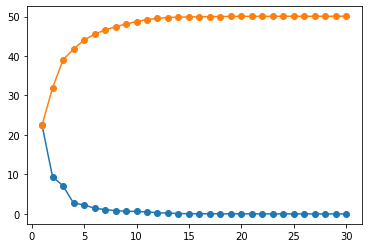

In [234]:
plt.plot(np.arange(1,31),pca_test.explained_variance_,'o-');
plt.plot(np.arange(1,31),np.cumsum(pca_test.explained_variance_),'o-');

# Why do we have this at max=50???

Transform the labels and the test set into 4 PC:s

In [0]:
pca = PCA(n_components=4)
npf_pca = pca.fit_transform(X)

test_pca = pca.transform(test)

In [0]:
npf_pca.shape, type(npf_pca), test_pca.shape, type(test_pca)

((724, 4), numpy.ndarray, (724, 4), numpy.ndarray)

In [0]:
npf_pca = pd.DataFrame(npf_pca, columns=["pca1","pca2","pca3","pca4"])

test_pca = pd.DataFrame(test_pca, columns=["pca1","pca2","pca3","pca4"])

#px.scatter_3d(data_frame=npf_pca,x="pca1",y="pca2",z="pca3",color=Y)

Split the train data into train and validation 

```X_train``` = training features  
```X_test``` = validation features  
```Y_train``` = training labels  
```Y_test``` = validation labels  

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(npf_pca,Y,random_state=42)

In [0]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((543, 4), (181, 4), (543,), (181,))

# Try different classification models

In [0]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

Use cross-validation to find the best model

In [0]:
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    print("%s:  %0.2f %%" % (name,score*100))

Nearest Neighbors:  61.88 %
Linear SVM:  60.77 %
RBF SVM:  58.56 %
Gaussian Process:  66.30 %
Decision Tree:  65.75 %
Random Forest:  62.43 %
Neural Net:  65.19 %
AdaBoost:  59.67 %
Naive Bayes:  60.77 %
QDA:  63.54 %


Use 10-fold cross-validation to find the best model

In [0]:
#cross validation
# DECLARATION #
kf = KFold(n_splits=10)
# CODE #
scores=[]
# iterate over k-folds
for train, val in kf.split(npf_pca):
    scores_iter=[]
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        clf.fit(npf_pca.iloc[train], Y[train])
        score = clf.score(npf_pca.iloc[val], Y[val])
        scores_iter.append(score)
        #print("{}:  {}".format(name,score))
    scores.append(scores_iter)
#print(scores)
scores=np.mean(scores,axis=0)
#print(scores)
for name, score in zip(names, scores):
     print("%s:  %0.2f %%" % (name,score*100))

Nearest Neighbors:  62.87 %
Linear SVM:  61.08 %
RBF SVM:  57.52 %
Gaussian Process:  68.41 %
Decision Tree:  61.51 %
Random Forest:  63.60 %
Neural Net:  67.17 %
AdaBoost:  59.70 %
Naive Bayes:  64.81 %
QDA:  65.21 %


Train the model 

We pick Gaussian processes 

In [0]:
model = GaussianProcessClassifier(1.0 * RBF(1.0))
#model = MLPClassifier(alpha=1, max_iter=1000)   # Wanted to test also the neural net

In [0]:
model.fit(npf_pca,Y)

GaussianProcessClassifier(copy_X_train=True, kernel=1**2 * RBF(length_scale=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

Predict values for npf_test_hidden.csv

In [0]:
#prediction = model.predict(test_pca)
prediction = model.predict(npf_pca)    # this is a test
prediction = labeler.inverse_transform(prediction)
#probs = model.predict_proba(test_pca)
probs = model.predict_proba(npf_pca)    # this is a test
#probs = np.max(probs, axis=1) 

In [0]:
# sum probabilities of event = p(1a) + p(1b) + p(2), which column contains p(nonevent)?
probs = np.sum(probs[:,:3], axis=1)

In [0]:
results_df = pd.DataFrame(zip(prediction,probs),columns=["event","p_event"])

In [248]:
results_df.head(10)

,event,p_event
0,nonevent,0.345689
1,nonevent,0.101492
2,nonevent,0.080002
3,nonevent,0.088518
4,nonevent,0.566253
5,II,0.933953
6,Ib,0.982578
7,Ib,0.993046
8,II,0.970542
9,Ib,0.990402


In [0]:
results_df.to_csv("/content/drive/My Drive/Colab Notebooks/answers.csv",index=False)